In [2]:
import pandas as pd
from pathlib import Path
from plots.loader import get_subfolders, load_multiple_timings, load_multiple_timings_scalability

folders = get_subfolders(Path("measurements/scalability/nlpkkt240"))
# folders += get_subfolders(Path("measurements/scalability/nlpkkt240-no-shuffle"))
folders += get_subfolders(Path("measurements/scalability/HV15R"))
folders += get_subfolders(Path("measurements/scalability/nlpkkt200"))
# folders = [folder for folder in folders if load_algorithm(folder) == 'drop_parallel']
# Returns the matrix name and a dictionary of ma pping from function to dataframe
ft = load_multiple_timings_scalability(folders)
assert len(ft) == 3
assert 'nlpkkt240' in ft

In [3]:
nlpkkt240 = ft['nlpkkt240']
nlpkkt240

,func,duration,bytes,node_id,nodes,mpi
0,bitmaps,2.958850e+06,0,31,32,32
0,deserialize,1.708100e+04,0,31,32,32
1,deserialize,1.599800e+04,0,31,32,32
2,deserialize,1.229400e+04,0,31,32,32
3,deserialize,1.215000e+04,0,31,32,32
...,...,...,...,...,...,...
510,build_csr,4.747680e+05,0,511,512,512
511,build_csr,5.132620e+05,0,511,512,512
512,build_csr,5.049940e+05,0,511,512,512
0,triplets_to_map,6.608000e+08,0,511,512,512


In [4]:
HV15R = ft['HV15R']
HV15R

,func,duration,bytes,node_id,nodes,mpi
0,bitmaps,2868950.0,0,31,32,32
0,deserialize,42663.0,0,31,32,32
1,deserialize,42714.0,0,31,32,32
2,deserialize,49980.0,0,31,32,32
3,deserialize,48612.0,0,31,32,32
...,...,...,...,...,...,...
510,build_csr,440642.0,0,511,512,512
511,build_csr,416514.0,0,511,512,512
512,build_csr,456894.0,0,511,512,512
0,triplets_to_map,368989000.0,0,511,512,512


In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np

# SCALING_FACTOR = 10**9 # for seconds
SCALING_FACTOR = 10**6
runs = 50
plt.rcParams['font.family'] = 'Computer Modern Roman'
plt.rcParams['text.usetex'] = True

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
STYLES = {
    # color, marker, offst, name
    "HV15R-512": ('darkcyan', 'h', (-60, -20), "\\textsc{NHWC}", None),
    "HV15R": ('darkcyan', 'h', (-60, -20), "\\textsc{NHWC}", None),
    "nlpkkt240": ('dodgerblue', 'h', (-60, -20), "\\textsc{NHWC}", None),
    "nlpkkt240-no-shuffle": ('darkolivegreen', 'h', (-60, -20), "\\textsc{NHWC}", None),
    "nlpkkt200": ('deeppink', 'h', (-75, -15), "\\textsc{Merged}", None),
    # "todo3": ('brown', '^', (-210, -135), "\\textsc{Tensor Macro}", 26),
    # "todo5": ('darkolivegreen', 's', (-120, -118), "\\textsc{Merged+Blocked}", None),
}

   key        avg         min         max
0   32  5469.6484  5403.80975  5534.95750
1   64  4091.6060  4040.92150  4159.43625
2  128  3138.8468  3113.20650  3165.96050
3  256  2583.2608  2559.53125  2624.96925
4  512  2389.7038  2359.66475  2440.84900
   key         avg          min         max
0   32  1468.86380  1447.195000  1483.88675
1   64  1094.49660  1078.130250  1101.14650
2  128   908.02110   868.568825   936.31455
3  256   798.59174   780.198500   826.12790
4  512   804.97592   790.744400   828.76910
   key        avg         min         max
0   32  571.87300  560.054300  583.850525
1   64  485.47564  474.734200  501.753300
2  128  452.28112  435.039875  470.023225
3  256  445.77476  429.530000  485.226825
4  512  559.63494  516.744000  685.755925


Text(0.5, 1.0, 'Squaring computation on multiple matrices')

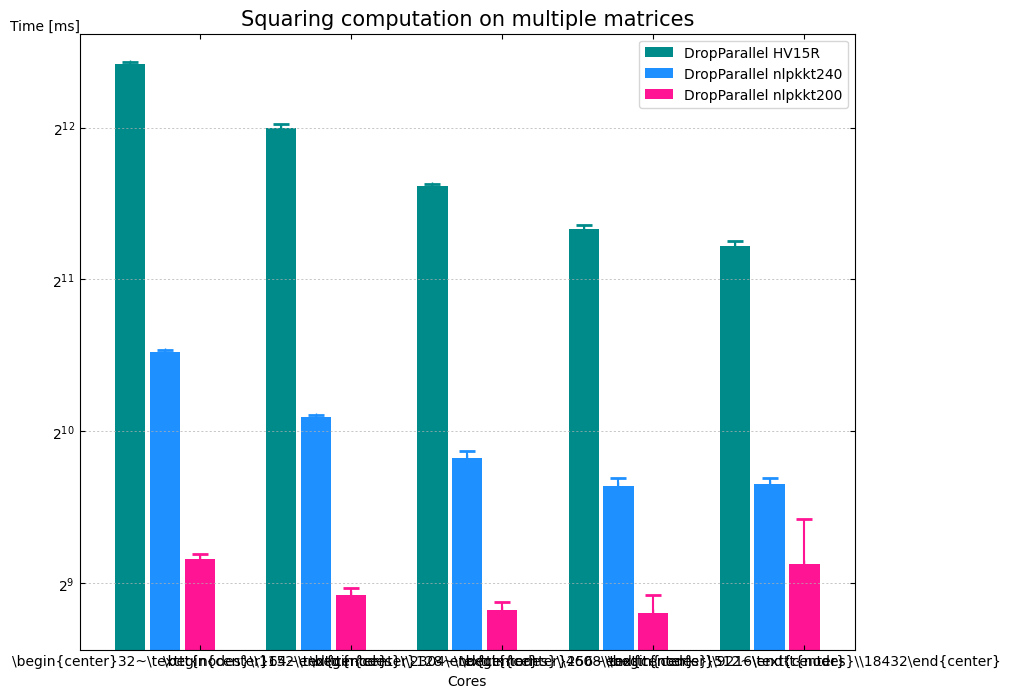

In [9]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

width = 0.2
x_offset = 0
#for algo, pretty_name in (('HV15R', 'DropParallel HV15R'), ('nlpkkt240', 'DropParallel nlpkkt240'), ('nlpkkt240-no-shuffle', 'DropParallel nlpkkt240 no shuffle'), ('nlpkkt200', 'DropParallel nlpkkt200')):
for algo, pretty_name in (('HV15R', 'DropParallel HV15R'), ('nlpkkt240', 'DropParallel nlpkkt240'), ('nlpkkt200', 'DropParallel nlpkkt200')):
    timings = ft[algo]
    func_data = timings[timings["func"] == 'gemm']

    timings = []
    for key, group in func_data.groupby('mpi'):
        value = group["duration"]
        avg = value.mean()/SCALING_FACTOR
        timings.append({
            "key": key,
            "avg": avg,
            "min": min(value.quantile(0.025)/SCALING_FACTOR, avg),
            "max": max(value.quantile(0.975)/SCALING_FACTOR, avg)
        })

    timings = pd.DataFrame(timings)

    print(timings)
    # Calculate the error bars
    eb = [
        (timings['avg'] - timings['min']),
        (timings['max'] - timings['avg'])
    ]

    keys = timings["key"]
    keysi = [i+x_offset for i in range(len(keys))]
    x_offset += width + 0.03
    values = timings["avg"]
    color, marker, offst, name, rotation = STYLES[algo]
    ax.bar(keysi, values, width, label=pretty_name, color=color)
    ax.errorbar(keysi, values, yerr=eb, fmt='|', capsize=6, capthick=2, color=color)

ax.set_xlabel("Cores")
ax.set_ylabel('Time [ms]',
        rotation='horizontal',
        loc='top',
        labelpad=-20)
ax.set_xticks(keysi, labels=[f"\\begin{{center}}{mpi}~\\texttt{{nodes}}\\\\{mpi * 36}\\end{{center}}"for mpi in keys])

plt.yscale('log', base=2)
ax.tick_params(axis='both', direction='in', which='major')
ax.grid(which='major', axis='y', linewidth=.5, dashes=(3,3))
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.legend()
ax.set_title("Squaring computation on multiple matrices", fontsize=15)

   key         avg          min         max
0   32  1468.86380  1447.195000  1483.88675
1   64  1094.49660  1078.130250  1101.14650
2  128   908.02110   868.568825   936.31455
3  256   798.59174   780.198500   826.12790
4  512   804.97592   790.744400   828.76910


Text(0.5, 1.0, 'Squaring computation on \\texttt{nlpkkt240}')

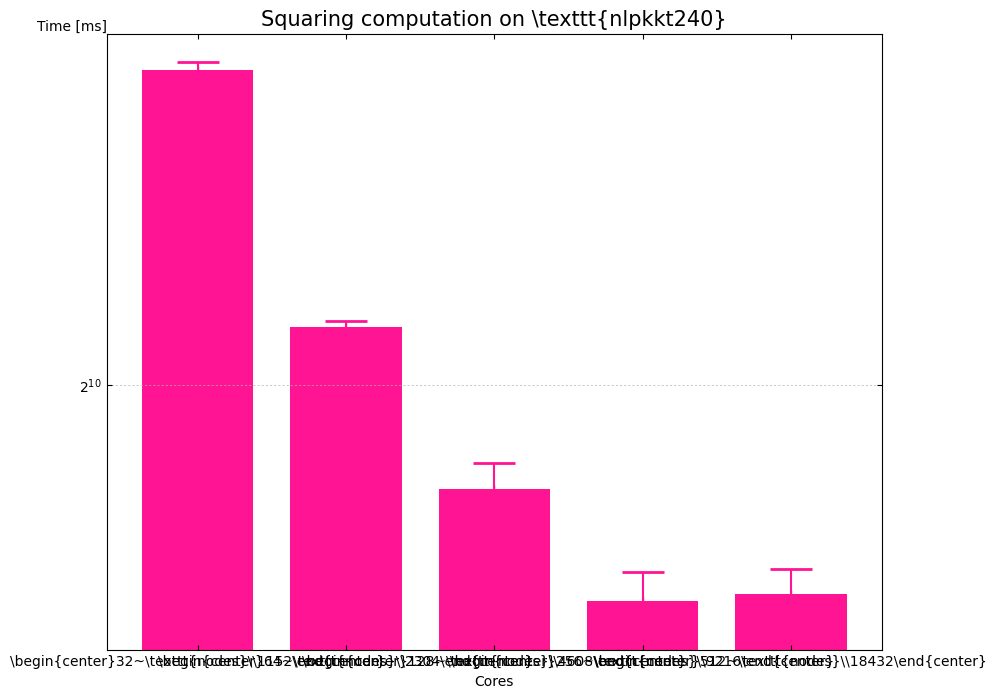

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

timings = []
for key, group in nlpkkt240.groupby('mpi'):
    gemm_s = group[group['func'] == 'gemm']['duration']
    gemm = gemm_s.mean()/SCALING_FACTOR
    
    timings.append({
        "key": key,
        "avg": gemm,
        "min": min(gemm_s.quantile(0.025)/SCALING_FACTOR, gemm),
        "max": max(gemm_s.quantile(0.975)/SCALING_FACTOR, gemm)
    })

timings = pd.DataFrame(timings)

print(timings)
# Calculate the error bars
eb = [
    (timings['avg'] - timings['min']),
    (timings['max'] - timings['avg'])
]

keys = timings["key"]
keysi = range(len(keys))
values = timings["avg"]
ax.bar(keysi, values, 0.75, label='GEMM', color=color)
ax.errorbar(keysi, values, yerr=eb, fmt='|', capsize=15, capthick=2, label=pretty_name, color=color)

ax.set_xlabel("Cores")
ax.set_ylabel('Time [ms]',
        rotation='horizontal',
        loc='top',
        labelpad=-20)
ax.set_xticks(keysi, labels=[f"\\begin{{center}}{mpi}~\\texttt{{nodes}}\\\\{mpi * 36}\\end{{center}}"for mpi in keys])

plt.yscale('log', base=2)
ax.tick_params(axis='both', direction='in', which='major')
ax.grid(which='major', axis='y', linewidth=.5, dashes=(3,3))
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.set_title("Squaring computation on \\texttt{" + "nlpkkt240" + "}", fontsize=15)